# Import the necessary packages

In [89]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 
from yellowbrick.model_selection import FeatureImportances
import sweetviz as sv
from imblearn.over_sampling import SMOTE
from yellowbrick.datasets import load_game
from yellowbrick.target import ClassBalance
from sklearn.impute import SimpleImputer

# Read the .CSV file

In [90]:
df = pd.read_csv("/kaggle/input/home-loan-approval/loan_sanction_train.csv")

In [91]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# Generating a sweetviz report

In [92]:
sw_report = sv.analyze(df)
sw_report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Check for Null and Duplicate Values

In [93]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [94]:
df.duplicated().sum()

0

### Dropping Duplicates

In [95]:
df.drop_duplicates(inplace = True )

### Dropping Load ID as it does not relevant in predicting a users loan status 

In [96]:
df.drop("Loan_ID", axis=1,inplace = True)

### Mapping Loan Status to a 0 and 1 

In [97]:
df["Credit_History"]= df["Credit_History"].map({0:"No",1:"Yes"})

# Shape of Dataset

In [98]:
print(f"Shape is {df.shape}")

Shape is (614, 12)


 # Printing all the column names

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    object 
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(3), int64(1), object(8)
memory usage: 62.4+ KB


# Unique values per column

In [100]:
unique_values_per_column = {}

for column in df.columns:
    if df[column].dtype == 'object':
        unique_values = df[column].unique().tolist()
        unique_values_per_column[column] = unique_values

for column, values in unique_values_per_column.items():
    print(f"Unique values for column '{column}':")
    for value in values:
        print(value)
    print() 
    

Unique values for column 'Gender':
Male
Female
nan

Unique values for column 'Married':
No
Yes
nan

Unique values for column 'Dependents':
0
1
2
3+
nan

Unique values for column 'Education':
Graduate
Not Graduate

Unique values for column 'Self_Employed':
No
Yes
nan

Unique values for column 'Credit_History':
Yes
No
nan

Unique values for column 'Property_Area':
Urban
Rural
Semiurban

Unique values for column 'Loan_Status':
Y
N



In [101]:
numerical_features = df.select_dtypes(include = ['number']).columns.tolist()
categorical_features = df.select_dtypes(exclude = ['number']).columns.tolist()

In [102]:
df[categorical_features]

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,Yes,Urban,Y
1,Male,Yes,1,Graduate,No,Yes,Rural,N
2,Male,Yes,0,Graduate,Yes,Yes,Urban,Y
3,Male,Yes,0,Not Graduate,No,Yes,Urban,Y
4,Male,No,0,Graduate,No,Yes,Urban,Y
...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,Yes,Rural,Y
610,Male,Yes,3+,Graduate,No,Yes,Rural,Y
611,Male,Yes,1,Graduate,No,Yes,Urban,Y
612,Male,Yes,2,Graduate,No,Yes,Urban,Y


# Replacing NA values with median and mode 

In [103]:

imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imputer.fit(df[numerical_features])
df[numerical_features] = imputer.transform(df[numerical_features])

In [104]:
imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
imputer.fit(df[categorical_features])
df[categorical_features] = imputer.transform(df[categorical_features])

In [105]:
df["Loan_Status"]= df["Loan_Status"].map({"N":0,"Y":1})
df["Credit_History"]= df["Credit_History"].map({"No":0,"Yes":1})
df["Gender"]= df["Gender"].map({"Male":0,"Female":1})
df["Dependents"]= df["Dependents"].map({"0":0,"1":1,"2":2,"3+":3})
df["Married"]= df["Married"].map({"No":0,"Yes":1})
df["Education"]= df["Education"].map({"Not Graduate":0,"Graduate":1})
df["Self_Employed"]= df["Self_Employed"].map({"No":0,"Yes":1})
df["Property_Area"]= df["Property_Area"].map({"Rural":1,"Semiurban":2,"Urban":3})

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    int64  
 1   Married            614 non-null    int64  
 2   Dependents         614 non-null    int64  
 3   Education          614 non-null    int64  
 4   Self_Employed      614 non-null    int64  
 5   ApplicantIncome    614 non-null    float64
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    int64  
 10  Property_Area      614 non-null    int64  
 11  Loan_Status        614 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 62.4 KB


In [107]:
df.isna().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

# Description of dataset

In [108]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Gender,614.0,0.182410,0.386497,0.0,0.00,0.0,0.00,1.0
Married,614.0,0.653094,0.476373,0.0,0.00,1.0,1.00,1.0
Dependents,614.0,0.744300,1.009623,0.0,0.00,0.0,1.00,3.0
Education,614.0,0.781759,0.413389,0.0,1.00,1.0,1.00,1.0
Self_Employed,614.0,0.133550,0.340446,0.0,0.00,0.0,0.00,1.0
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.50,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.00,1188.5,2297.25,41667.0
LoanAmount,614.0,146.412162,84.037468,9.0,100.25,129.0,164.75,700.0
Loan_Amount_Term,614.0,342.000000,64.372489,12.0,360.00,360.0,360.00,480.0
Credit_History,614.0,0.855049,0.352339,0.0,1.00,1.0,1.00,1.0


# Correlation Matrix

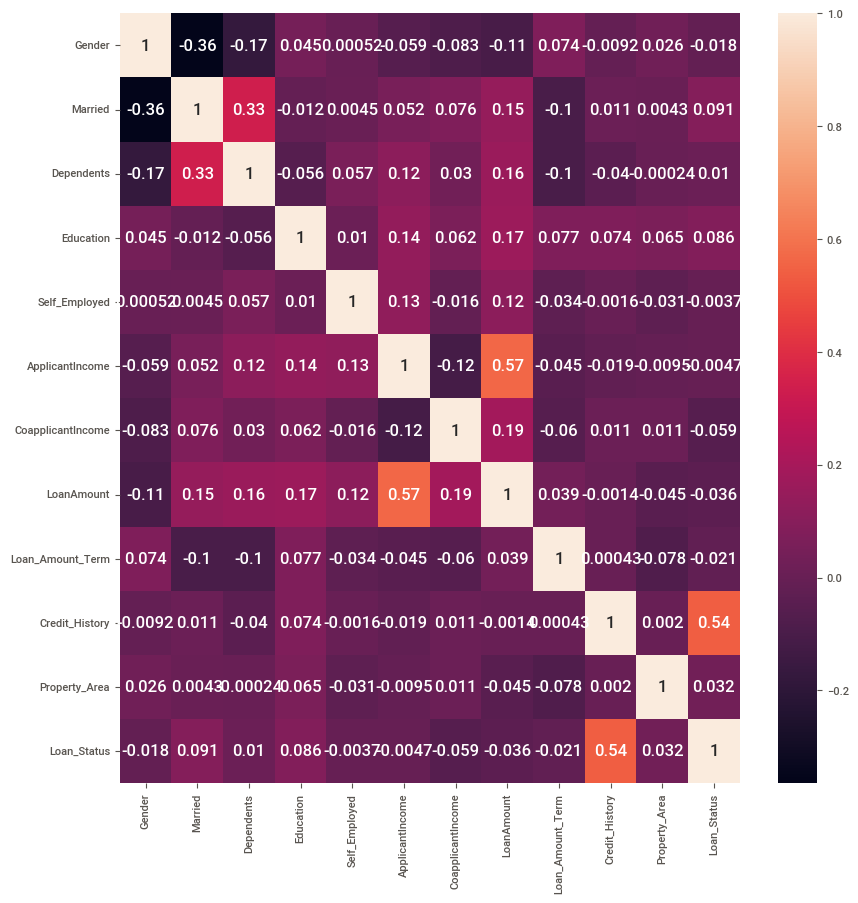

In [109]:


plt.figure(figsize=(10,10))
correlation_mat = df.corr()
sns.heatmap(correlation_mat, annot = True)
plt.show()

# Are the classes balanced?

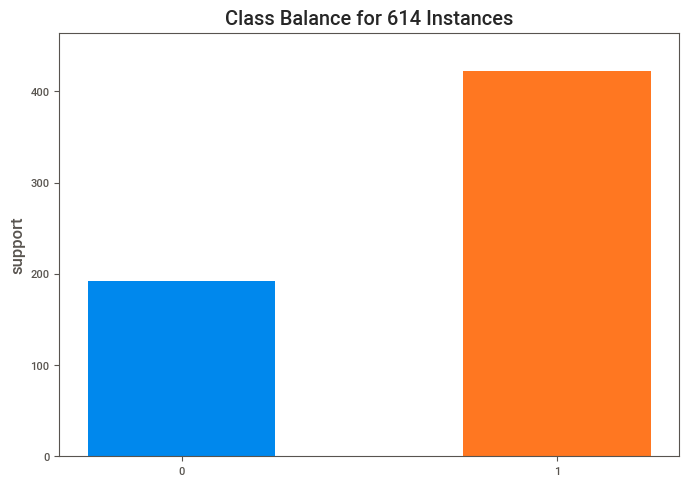

<AxesSubplot:title={'center':'Class Balance for 614 Instances'}, ylabel='support'>

In [110]:
visualizer = ClassBalance(labels=["0","1"])
visualizer.fit(df["Loan_Status"])       
visualizer.show()   

In [111]:
x_train = df.iloc[:,:-1]
y_train = df["Loan_Status"]

# Solving class imbalance using SMOTE

In [112]:
sm = SMOTE(random_state= 2)
oversampled_X, oversampled_Y = sm.fit_resample(x_train, y_train)
df = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

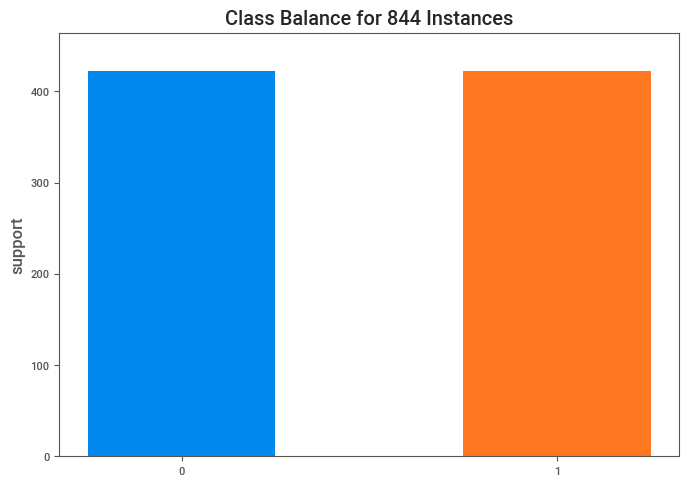

<AxesSubplot:title={'center':'Class Balance for 844 Instances'}, ylabel='support'>

In [113]:
visualizer = ClassBalance(labels=["0","1"])
visualizer.fit(df["Loan_Status"])        # Fit the data to the visualizer
visualizer.show() 

# EDA

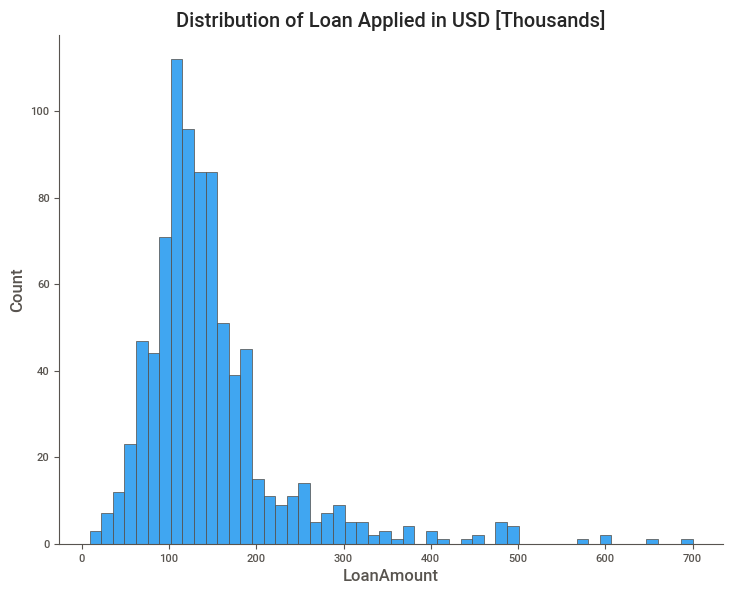

In [114]:
loan_amount = sns.displot(data=df, x='LoanAmount',  legend=True)
plt.title('Distribution of Loan Applied in USD [Thousands]')
loan_amount.fig.set_figwidth(8)
loan_amount.fig.set_figheight(6)

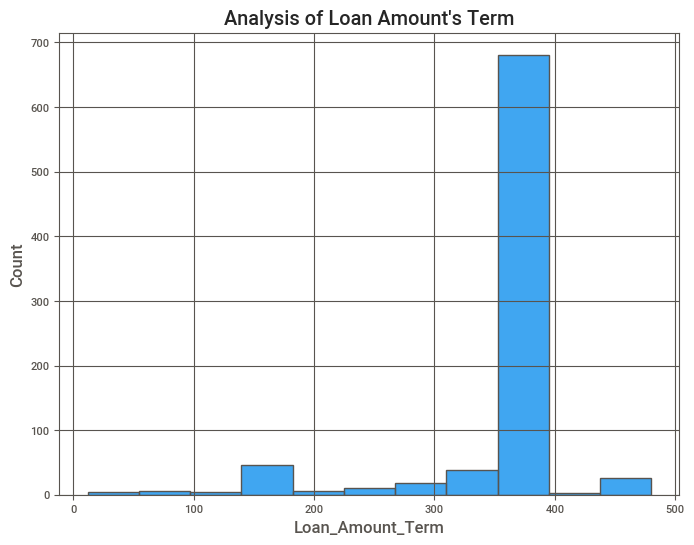

In [115]:
plt.figure(figsize=(8,6))
sns.histplot(x='Loan_Amount_Term', data=df)
plt.title("Analysis of Loan Amount's Term")
plt.grid()
plt.show()

In [116]:
df['Gender'].value_counts()

0    712
1    132
Name: Gender, dtype: int64

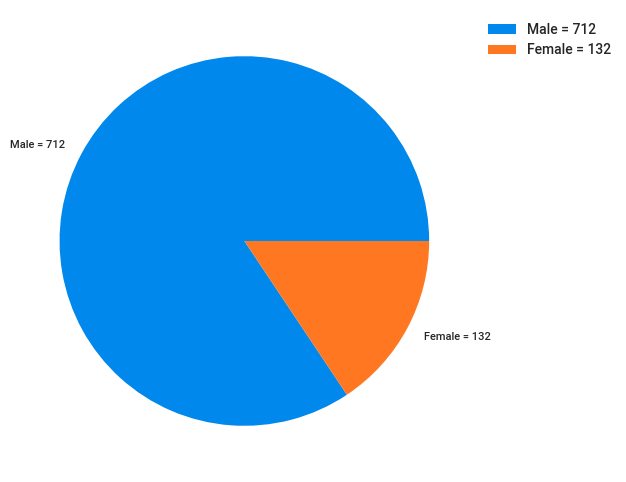

In [117]:
gender = np.array(df['Gender'].value_counts(sort=True))

labels = ['Male = 712','Female = 132']

plt.figure(figsize=(8,6))
plt.pie(gender, labels=labels,shadow=False)
plt.legend(labels=labels, 
           bbox_to_anchor=(1,1))
plt.show()

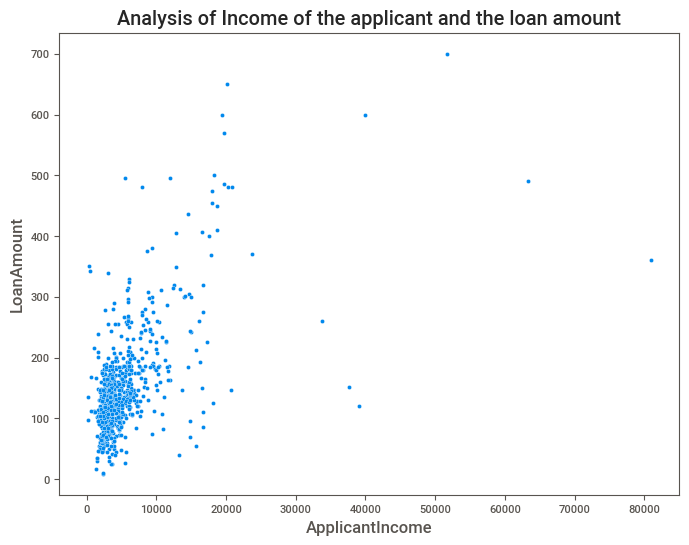

In [118]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='ApplicantIncome', y='LoanAmount', data=df)
plt.title('Analysis of Income of the applicant and the loan amount')
plt.show()

# Model validation using Train/Test Split

In [119]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.2, random_state = 0)

## Standard Scalar converts the data to a mean of 0 and std of 1 

In [120]:
# from sklearn.preprocessing import StandardScaler
# ss = StandardScaler()
# x_train= ss.fit_transform(x_train)
# x_test = ss.transform(x_test)

# Fitting the Models

I have taken: Logistic Regression , SVM , LDA , Decision Tree , Random Forest and KNearestNeighbor

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Training Accuracy: 73.72708757637476
Testing Accuracy: 75.60975609756098
Testing MAE: 24.390243902439025
[[13 10]
 [20 80]]
              precision    recall  f1-score   support

           0       0.39      0.57      0.46        23
           1       0.89      0.80      0.84       100

    accuracy                           0.76       123
   macro avg       0.64      0.68      0.65       123
weighted avg       0.80      0.76      0.77       123



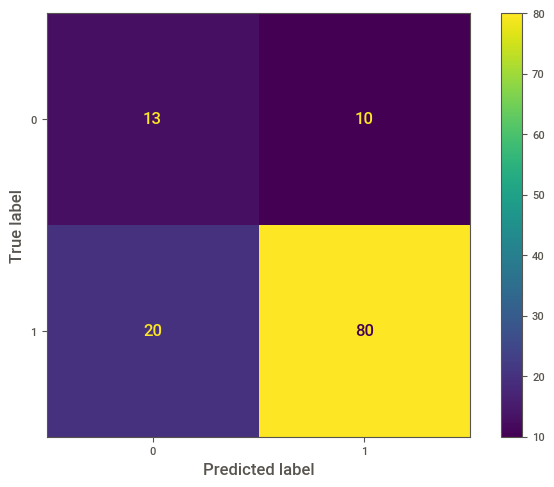

In [121]:
lgr = LogisticRegression(solver='lbfgs', max_iter=50)
# lgr = LogisticRegression(penalty='l2',C=0.1)
lgr.fit(x_train,y_train)
test_pred=lgr.predict(x_test)
train_pred = lgr.predict(x_train)

acc_lgr = accuracy_score(test_pred,y_test)
mae_lgr = mean_absolute_error(y_test, test_pred)

print(f"Training Accuracy: {accuracy_score(train_pred,y_train)*100}")
print(f"Testing Accuracy: {accuracy_score(test_pred,y_test)*100}")
print(f"Testing MAE: {mean_absolute_error(y_test, test_pred)*100}")

# sklearn.metrics.
print(f"{confusion_matrix(test_pred,y_test)}")
print(f"{classification_report(test_pred,y_test)}")
from sklearn import metrics
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(test_pred,y_test), display_labels = [0,1])
cm_display.plot()
plt.show()

In [122]:
from sklearn.neighbors import KNeighborsClassifier

# sqrt(21)/n = k 
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(x_train,y_train)
test_pred=knn.predict(x_test)
train_pred = knn.predict(x_train)

acc_knn = accuracy_score(test_pred,y_test)
mae_knn = mean_absolute_error(y_test, test_pred)


print(f"Training Accuracy: {accuracy_score(train_pred,y_train)*100}")
print(f"Testing Accuracy: {accuracy_score(test_pred,y_test)*100}")
print(f"Testing MAE: {mean_absolute_error(y_test, test_pred)*100}")

print(f"{confusion_matrix(test_pred,y_test)}")
print(f"{classification_report(test_pred,y_test)}")


Training Accuracy: 79.63340122199592
Testing Accuracy: 60.16260162601627
Testing MAE: 39.83739837398374
[[ 4 20]
 [29 70]]
              precision    recall  f1-score   support

           0       0.12      0.17      0.14        24
           1       0.78      0.71      0.74        99

    accuracy                           0.60       123
   macro avg       0.45      0.44      0.44       123
weighted avg       0.65      0.60      0.62       123



In [123]:
svc = SVC()
svc.fit(x_train,y_train)
test_pred=svc.predict(x_test)
train_pred = svc.predict(x_train)

acc_svc = accuracy_score(test_pred,y_test)
mae_svc = mean_absolute_error(y_test, test_pred)


print(f"Training Accuracy: {accuracy_score(train_pred,y_train)*100}")
print(f"Testing Accuracy: {accuracy_score(test_pred,y_test)*100}")
print(f"Testing MAE: {mean_absolute_error(y_test, test_pred)*100}")

print(f"{confusion_matrix(test_pred,y_test)}")
print(f"{classification_report(test_pred,y_test)}")


Training Accuracy: 68.0244399185336
Testing Accuracy: 73.17073170731707
Testing MAE: 26.82926829268293
[[ 0  0]
 [33 90]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.73      0.85       123

    accuracy                           0.73       123
   macro avg       0.50      0.37      0.42       123
weighted avg       1.00      0.73      0.85       123



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [124]:
lda = LDA(n_components = 1)
lda.fit(x_train,y_train)
test_pred=lda.predict(x_test)
train_pred = lda.predict(x_train)

acc_lda = accuracy_score(test_pred,y_test)
mae_lda = mean_absolute_error(y_test, test_pred)


print(f"Training Accuracy: {accuracy_score(train_pred,y_train)*100}")
print(f"Testing Accuracy: {accuracy_score(test_pred,y_test)*100}")
print(f"Testing MAE: {mean_absolute_error(y_test, test_pred)*100}")

print(f"{confusion_matrix(test_pred,y_test)}")
print(f"{classification_report(test_pred,y_test)}")

Training Accuracy: 80.65173116089613
Testing Accuracy: 83.73983739837398
Testing MAE: 16.260162601626014
[[15  2]
 [18 88]]
              precision    recall  f1-score   support

           0       0.45      0.88      0.60        17
           1       0.98      0.83      0.90       106

    accuracy                           0.84       123
   macro avg       0.72      0.86      0.75       123
weighted avg       0.91      0.84      0.86       123



In [125]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train,y_train)
test_pred=decision_tree.predict(x_test)
train_pred = decision_tree.predict(x_train)

acc_dt = accuracy_score(test_pred,y_test)
mae_dt = mean_absolute_error(y_test, test_pred)


print(f"Training Accuracy: {accuracy_score(train_pred,y_train)*100}")
print(f"Testing Accuracy: {accuracy_score(test_pred,y_test)*100}")
print(f"Testing MAE: {mean_absolute_error(y_test, test_pred)*100}")

print(f"{confusion_matrix(test_pred,y_test)}")
print(f"{classification_report(test_pred,y_test)}")

Training Accuracy: 100.0
Testing Accuracy: 68.29268292682927
Testing MAE: 31.70731707317073
[[20 26]
 [13 64]]
              precision    recall  f1-score   support

           0       0.61      0.43      0.51        46
           1       0.71      0.83      0.77        77

    accuracy                           0.68       123
   macro avg       0.66      0.63      0.64       123
weighted avg       0.67      0.68      0.67       123



In [126]:
random_forest = RandomForestClassifier(n_estimators=200,min_samples_split=4)
random_forest.fit(x_train,y_train)
test_pred=random_forest.predict(x_test)
train_pred = random_forest.predict(x_train)


acc_rf = accuracy_score(test_pred,y_test)
mae_rf = mean_absolute_error(y_test, test_pred)


print(f"Training Accuracy: {accuracy_score(train_pred,y_train)*100}")
print(f"Testing Accuracy: {accuracy_score(test_pred,y_test)*100}")
print(f"Testing MAE: {mean_absolute_error(y_test, test_pred)*100}")

print(f"{confusion_matrix(test_pred,y_test)}")
print(f"{classification_report(test_pred,y_test)}")

Training Accuracy: 99.18533604887983
Testing Accuracy: 79.67479674796748
Testing MAE: 20.32520325203252
[[15  7]
 [18 83]]
              precision    recall  f1-score   support

           0       0.45      0.68      0.55        22
           1       0.92      0.82      0.87       101

    accuracy                           0.80       123
   macro avg       0.69      0.75      0.71       123
weighted avg       0.84      0.80      0.81       123



In [127]:
models = pd.DataFrame({'Model': ['Logistic Regression', 'SVC', 'Lda', 'Decision Tree Classifier','Random Forest Classifier',"KNN"] ,
   'Score': [acc_lgr,acc_svc,acc_lda,acc_dt,acc_rf,acc_knn], 'MAE': [mae_lgr,mae_svc,mae_lda,mae_dt,mae_rf,mae_knn]})


# Print the data
models.sort_values(by='Score',ascending = False)

,Model,Score,MAE
2,Lda,0.837398,0.162602
4,Random Forest Classifier,0.796748,0.203252
0,Logistic Regression,0.756098,0.243902
1,SVC,0.731707,0.268293
3,Decision Tree Classifier,0.682927,0.317073
5,KNN,0.601626,0.398374


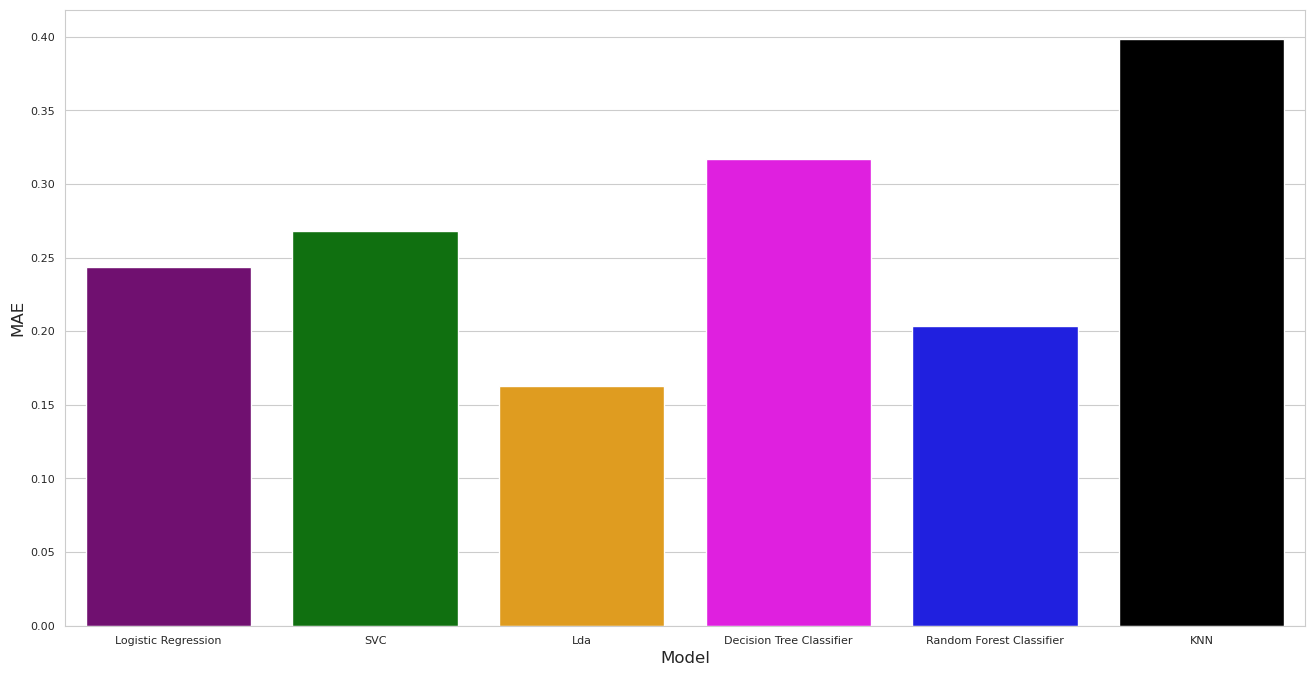

In [128]:
colors = ["purple", "green", "orange", "magenta","blue","black"]
sns.set_style("whitegrid")
plt.figure(figsize=(16,8))
plt.ylabel("Accuracy %")
plt.xlabel("Algorithms")
sns.barplot(x=models['Model'],y=models['MAE'], palette=colors )
plt.show()

## Selecting LDA since it has the highest accuracy.

## Feature Importance 

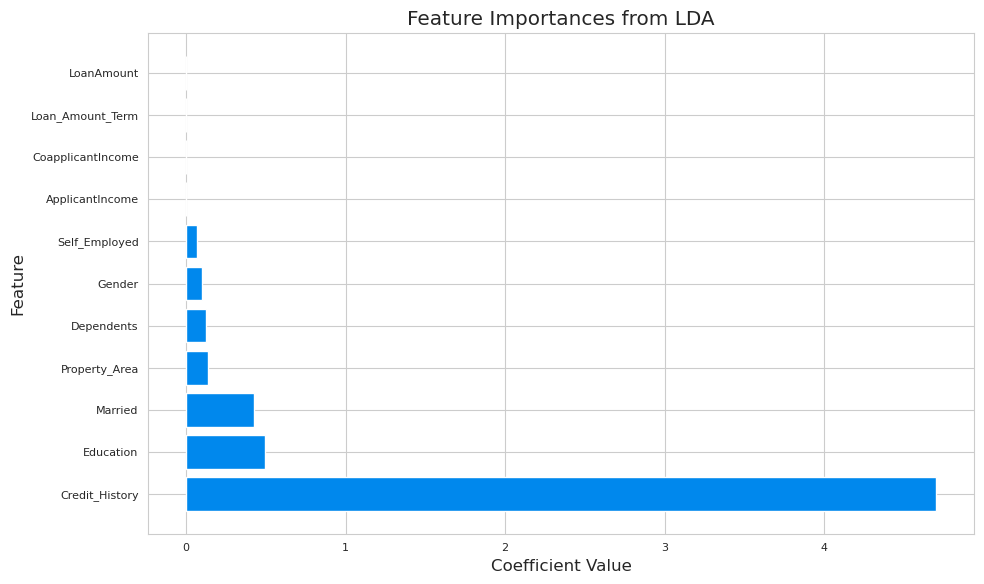

In [129]:
coefficients = lda.coef_[0]
feature_names = x_train.columns 

sorted_indices = np.argsort(coefficients)[::-1]
sorted_coefficients = coefficients[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]


plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_names)), sorted_coefficients, align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importances from LDA')
plt.tight_layout()
plt.show()

# Saving the svc model to be used in making predictions

In [130]:
filename = 'home.pickle' 
joblib.dump(lda, filename)

['home.pickle']